# 1. Importing Necessary Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# 2. Accessing the dataset

In [4]:
df_train = pd.read_csv("./dataset/train.csv")
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
len(df_train)

42000

In [6]:
train_labels = df_train.iloc[:,0].values
train_labels

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

In [7]:
train_labels.shape

(42000,)

In [8]:
train_labels = train_labels.reshape(-1,1)
encoder = OneHotEncoder(sparse_output=False)
train_labels = encoder.fit_transform(train_labels)

In [9]:
train_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
train_pixels = df_train.iloc[:,1:].values
train_pixels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [11]:
train_pixels.shape

(42000, 784)

In [12]:
X_train,X_test,y_train,y_test = train_test_split(train_pixels,train_labels,test_size=0.2,random_state=42)

# Implementing Neural Network

In [13]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.train_loss = []
        self.test_loss = []

        # PARAMETER INITIALIZATION
        self.weights1 = np.random.randn(self.input_size, self.hidden_size_1) * 0.01
        self.biases1 = np.zeros((1, self.hidden_size_1))

        self.weights2 = np.random.randn(self.hidden_size_1, self.hidden_size_2) * 0.01
        self.biases2 = np.zeros((1, self.hidden_size_2))

        self.weights3 = np.random.randn(self.hidden_size_2, self.output_size) * 0.01
        self.biases3 = np.zeros((1, self.output_size))

    def __str__(self):
        return f"Neural Network Layout:\n\nInput Layer: {self.input_size} neurons\nHidden Layer 1: {self.hidden_size_1} neurons\nHidden Layer 2: {self.hidden_size_2} neurons\nOutput Layer: {self.output_size} neurons\nLoss Function: CrossEntropyLoss"

    def softmax(self, x):
        """Correct softmax implementation"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability trick
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def cross_entropy_loss(self, y_true, y_pred):
        """Computes the categorical cross-entropy loss"""
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    def forward(self, X):
        """Forward propagation"""
        self.z1 = np.dot(X, self.weights1) + self.biases1
        self.a1 = self.relu(self.z1)

        self.z2 = np.dot(self.a1, self.weights2) + self.biases2
        self.a2 = self.relu(self.z2)

        self.z3 = np.dot(self.a2, self.weights3) + self.biases3
        self.a3 = self.softmax(self.z3)  # Output layer with softmax

        return self.a3

    def backpropagate(self, X, y_true):
        """Backpropagation with categorical cross-entropy loss"""
        m = X.shape[0]

        # Output layer error
        dz3 = self.a3 - y_true  # Gradient of softmax + cross-entropy
        dw3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        # Hidden layer 2 error
        dz2 = np.dot(dz3, self.weights3.T) * self.relu_derivative(self.z2)
        dw2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        # Hidden layer 1 error
        dz1 = np.dot(dz2, self.weights2.T) * self.relu_derivative(self.z1)
        dw1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update parameters
        self.weights3 -= self.learning_rate * dw3
        self.biases3 -= self.learning_rate * db3
        self.weights2 -= self.learning_rate * dw2
        self.biases2 -= self.learning_rate * db2
        self.weights1 -= self.learning_rate * dw1
        self.biases1 -= self.learning_rate * db1

    def train(self, X, y, epochs=100):
        """Train the neural network"""
        for epoch in range(epochs):
            y_pred = self.forward(X)  # Forward pass
            loss = self.cross_entropy_loss(y, y_pred)  # Compute loss
            self.train_loss.append(loss)
            self.backpropagate(X, y)  # Backpropagation

            if epoch % 10 == 0:
                print(f"Epoch: {epoch} | Train Loss: {loss:.4f}")

    def test(self, X, y, epochs=100):
        """Test the neural network"""
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.cross_entropy_loss(y, y_pred)
            self.test_loss.append(loss)

            if epoch % 10 == 0:
                print(f"Epoch: {epoch} | Test Loss: {loss:.4f}")


In [14]:
NN = NeuralNetwork(input_size=784,hidden_size_1=16,hidden_size_2=16,output_size=10)
print(NN)

Neural Network Layout:

Input Layer: 784 neurons
Hidden Layer 1: 16 neurons
Hidden Layer 2: 16 neurons
Output Layer: 10 neurons
Loss Function: CrossEntropyLoss


In [15]:
NN.train(X_train,y_train,epochs=201)

Epoch: 0 | Train Loss: 2.3029
Epoch: 10 | Train Loss: 2.2921
Epoch: 20 | Train Loss: 2.2515
Epoch: 30 | Train Loss: 2.0230
Epoch: 40 | Train Loss: 1.3287
Epoch: 50 | Train Loss: 1.7549
Epoch: 60 | Train Loss: 1.3745
Epoch: 70 | Train Loss: 1.6580
Epoch: 80 | Train Loss: 1.1297
Epoch: 90 | Train Loss: 1.0378
Epoch: 100 | Train Loss: 1.0048
Epoch: 110 | Train Loss: 0.9319
Epoch: 120 | Train Loss: 0.8825
Epoch: 130 | Train Loss: 0.8949
Epoch: 140 | Train Loss: 0.6705
Epoch: 150 | Train Loss: 0.5876
Epoch: 160 | Train Loss: 0.4970
Epoch: 170 | Train Loss: 0.5061
Epoch: 180 | Train Loss: 0.4780
Epoch: 190 | Train Loss: 0.4146
Epoch: 200 | Train Loss: 0.3917


In [16]:
NN.test(X_test,y_test,epochs=201)

Epoch: 0 | Test Loss: 0.4045
Epoch: 10 | Test Loss: 0.4045
Epoch: 20 | Test Loss: 0.4045
Epoch: 30 | Test Loss: 0.4045
Epoch: 40 | Test Loss: 0.4045
Epoch: 50 | Test Loss: 0.4045
Epoch: 60 | Test Loss: 0.4045
Epoch: 70 | Test Loss: 0.4045
Epoch: 80 | Test Loss: 0.4045
Epoch: 90 | Test Loss: 0.4045
Epoch: 100 | Test Loss: 0.4045
Epoch: 110 | Test Loss: 0.4045
Epoch: 120 | Test Loss: 0.4045
Epoch: 130 | Test Loss: 0.4045
Epoch: 140 | Test Loss: 0.4045
Epoch: 150 | Test Loss: 0.4045
Epoch: 160 | Test Loss: 0.4045
Epoch: 170 | Test Loss: 0.4045
Epoch: 180 | Test Loss: 0.4045
Epoch: 190 | Test Loss: 0.4045
Epoch: 200 | Test Loss: 0.4045


In [17]:
epochs = []
for i in range(201):
    epochs.append(i)

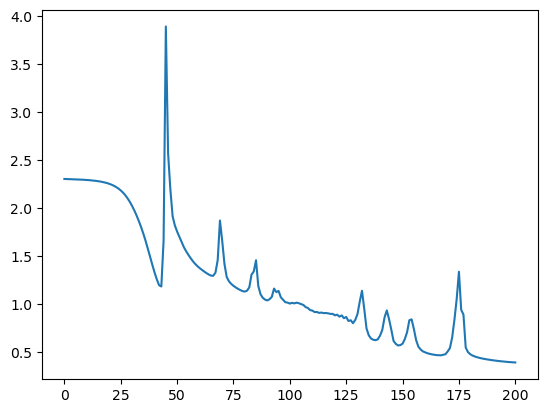

In [18]:
plt.plot(epochs,NN.train_loss)

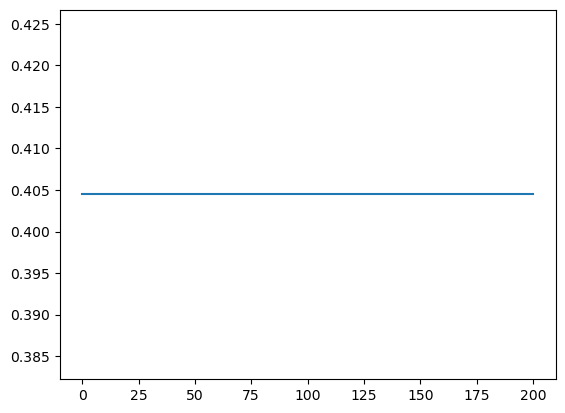

In [20]:
plt.plot(epochs,NN.test_loss)